In [285]:
import numpy as np
import matplotlib.pyplot as plt

In [286]:
class Data_generator:
    def __init__(self, _alpha_r=0, _beta_r=1, _d=1, _alpha_u=0, _beta_u=1, _gamma=1, _theta=0, __lambda=1):
        self.alpha_r = _alpha_r
        self.beta_r = _beta_r
        self.d = _d
        self.alpha_u = _alpha_u
        self.beta_u = _beta_u
        self.gamma = _gamma
        self.theta = _theta
        self._lambda = __lambda

    def gen_data(self, n=1000, T=100):
        r=np.zeros((T,n)) #r yield
        eps=np.zeros(n)
        u=np.zeros(n)
        for i in range(T):
            u = self.alpha_u+self.beta_u*u+self.gamma*eps**2+self.theta*np.where(eps<0,eps**2,0)+np.random.exponential(scale=1/self._lambda,size=n)
            eps=np.random.standard_t(df=self.d, size=n)*np.sqrt(u)
            r[i]=self.alpha_r+self.beta_r*u+eps
        return r
    
    def gen_data_full(self, n=1000, T=100):
        r=np.zeros((T,n)) #r yield
        eps_list=np.zeros((T,n))
        u_list=np.zeros((T,n))
        u=np.zeros(n)
        eps=np.zeros(n)
        r[0]=self.alpha_r
        for i in range(1, T):
            u = self.alpha_u+self.beta_u*u+self.gamma*eps**2+self.theta*np.where(eps<0,eps**2,0)+np.random.exponential(scale=1/self._lambda,size=n)
            eps=np.random.standard_t(df=self.d, size=n)*np.sqrt(u)
            u_list[i]=u
            eps_list[i]=eps
            r[i]=self.alpha_r+self.beta_r*u+eps
        return r, u_list, eps_list
    
    
    
#DG = Data_generator(0.2, 0.2, 6.0, 0.6, 0.4, 0.1, 0.02, 2.5)
#print(DG.gen_data_full(5, 5))    
#Test texts

In [287]:
params = (1, 1., 5., 0, 1., 0.1, 0., 0.5)

In [288]:
DG = Data_generator(*params)
data = DG.gen_data_full(10000, 2)

In [289]:
print(data[0])

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.99987079 3.723011   5.59784014 ... 1.05198958 0.93940499 2.47956858]]


In [290]:
import numpy as np
from scipy.stats import t, expon


def updaterr(r_t, eps_t, r_t1, eps_t1, alpha_r, beta_r, d, alpha_u, beta_u, gamma, theta, _lambda):
    u_t1 = (r_t1 - alpha_r - eps_t1) / beta_r
    w_t = alpha_u + beta_u * u_t1 + gamma * eps_t1 ** 2 + theta * (eps_t1 < 0) * eps_t1 ** 2
    nu_t = eps_t * np.sqrt(beta_r / (r_t - eps_t - alpha_r))
    eta_t = (r_t - eps_t - alpha_r) / beta_r - w_t
    p = t.pdf(nu_t, d) * expon.pdf(eta_t, scale=1 / _lambda) / np.sqrt(beta_r * (r_t - eps_t - alpha_r))
    return p


class TEST_SAMPLER:
    """test sampler"""
    samples = []
    def __init__(self, T, params):
        self.alpha_r, self.beta_r, self.d, self.alpha_u, self.beta_u,self.gamma, self.theta, self._lambda = params
        self.params = params
        self.T = T 
        
    def sample(self, sample_num:int, r):
        samples = np.zeros((self.T, sample_num))
        weights = np.ones(sample_num)
        for i in range(1, self.T): 
            for j in range(sample_num):
                samples[i][j] = self.policy(r[i][j], r[i-1][j], samples[i-1][j])
                weights[j] *= updaterr(r[i][j], samples[i][j], r[i-1][j], samples[i-1][j], *self.params)/self.policy_density(r[i][j], samples[i][j], r[i-1][j], samples[i-1][j])
        weights *= sample_num/np.sum(weights)
        return samples, weights

    def policy(self, rt, rt1, et1):
        """sampling policy"""
        return rt - self.alpha_r - expon.rvs(scale=0.8)

    def policy_density(self, rt, et, rt1, et1): 
        """pdf of policy"""
        return  expon.pdf(rt - self.alpha_r - et, scale=0.8)

In [291]:
sampler = TEST_SAMPLER(2, params)
samples, weights = sampler.sample(10000, data[0])

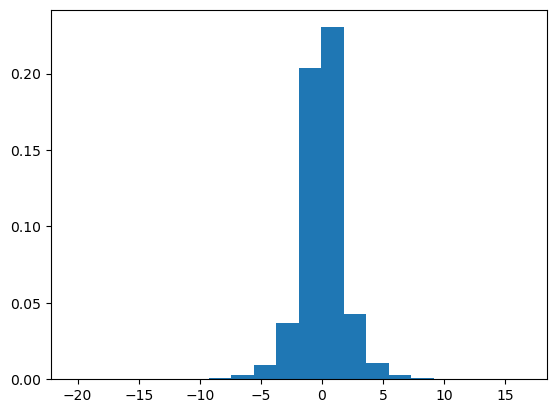

In [292]:
plt.hist(data[2][1], density=True, bins=20)
plt.show()

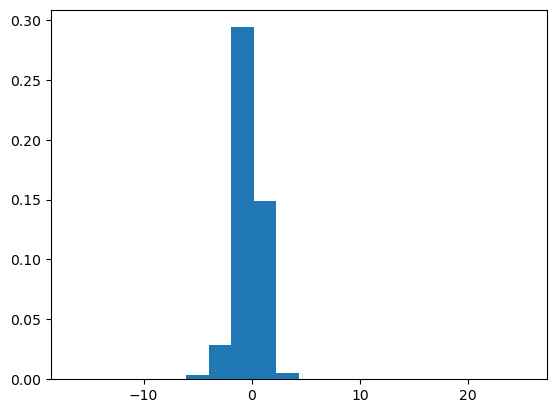

In [293]:
plt.hist(samples[1], weights=weights, density=True, bins=20)
plt.show()

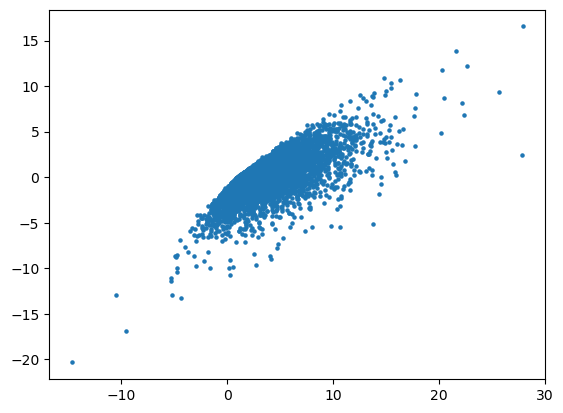

In [294]:
plt.scatter(data[0][1], data[2][1], s=5)
plt.show()

In [295]:
index = np.random.choice(list(range(10000)), p=weights/10000, size=(10000))

In [296]:
ESS = 10000**2/np.sum(np.power(weights, 2))
print(ESS)

3942.8751443521287


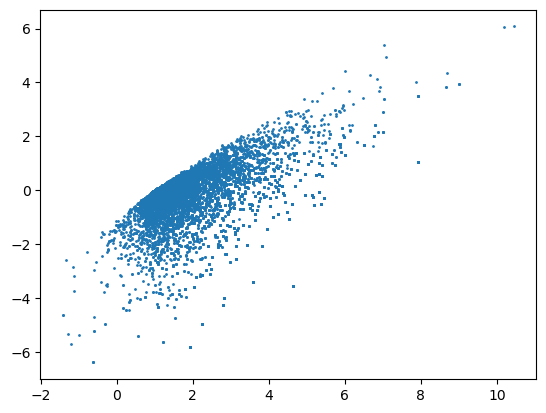

In [297]:
plt.scatter((data[0][1])[index], (samples[1])[index], s=1)
#plt.scatter(data[0][1], data[2][1], s=1)
plt.show()

In [298]:
print(np.var(data[2][1]))
print(np.var((samples[1])[index]))

3.201250065977437
1.206483963505557
